In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns; sns.set()
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from tensorflow.keras.datasets import cifar10

Used 'from tensorflow.keras import datasets', because my 'keras' is installed within 'tensorflow'. In case while checking, if the line doesn't work, please try 'from keras import datasets'.

## Q.1. Load the CIFAR-10 dataset

The CIFAR10 dataset comprises 50000 training images (divided in 5 batches) and 10000 test images, each representing an object in a coloured image. Each input image is represented by an array of 1024 RGB values (3x8-bit integers, values range from 0 - 255).

In [2]:
(X_trainBatch, y_trainBatch), (X_testBatch, y_testBatch) = cifar10.load_data()

In [3]:
print(X_trainBatch.shape)
print(y_trainBatch.shape)
print(X_testBatch.shape)
print(y_testBatch.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Visualize all Images

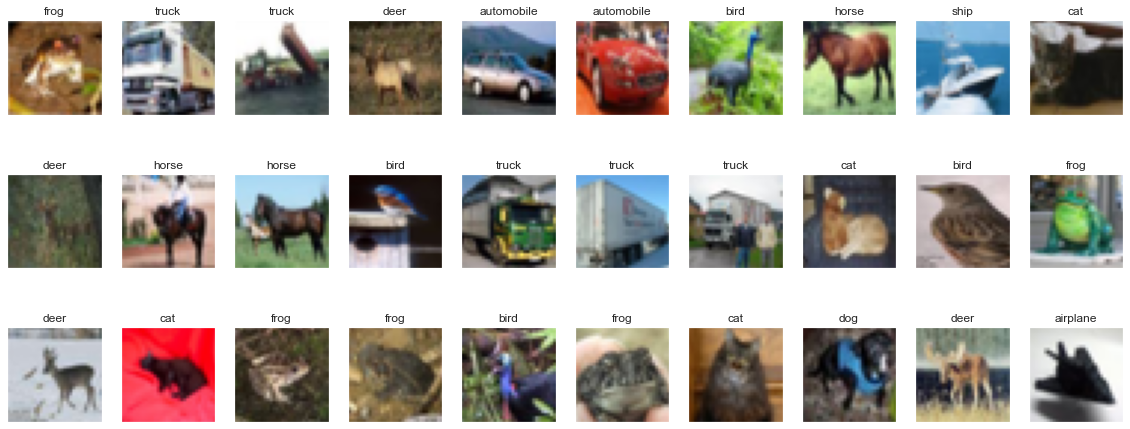

In [5]:
fig, axes = plt.subplots(ncols=10, nrows=3, figsize=(20, 8))
index = 0
for i in range(3):
    for j in range(10):
        axes[i,j].set_title(labels[y_trainBatch[index][0]])
        axes[i,j].imshow(X_trainBatch[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## Q.2. Convert all the images into gray scale

In [6]:
X_trainBatch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_trainBatch])
X_testBatch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_testBatch])

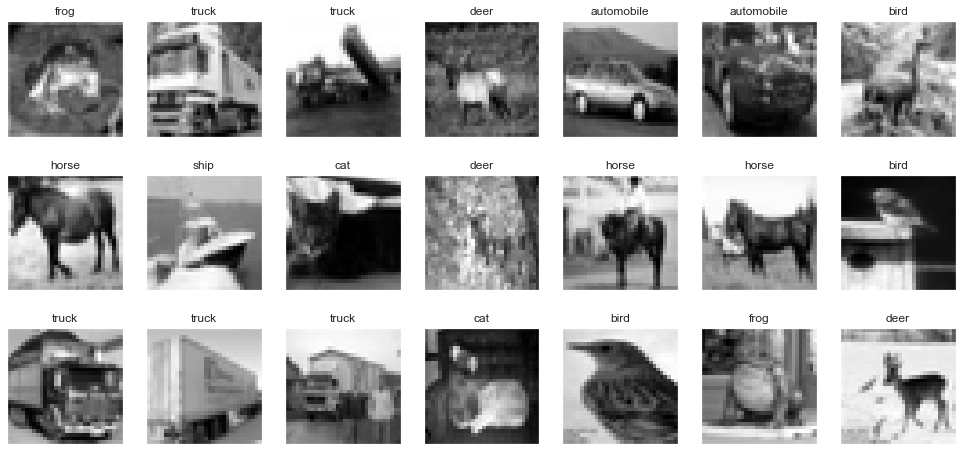

In [7]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(labels[y_trainBatch[index][0]])
        axes[i,j].imshow(X_trainBatch[index], cmap = 'gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [8]:
print(X_trainBatch.shape)
print(X_testBatch.shape)

(50000, 32, 32)
(10000, 32, 32)


## Distribution of labels in CIFAR-10

In [9]:
def plotLabelHist(y_test, y_train, title):
    fig, ax = plt.subplots(1,2,figsize=(13,5)); b=np.arange(0,11)-0.5
    h_t = ax[0].hist(y_test, edgecolor='gray', align='mid', bins=b )
    ax[0].set_xticks((np.arange(0,10))); ax[0].grid(axis='y', linestyle=':')
    ax[0].set_title("Distribution of labels in "+title+" Test")
    h_tr = ax[1].hist(y_train, edgecolor='gray', align='mid', bins=b )
    ax[1].set_xticks((np.arange(0,10))); ax[1].grid(axis='y', linestyle=':')
    ax[1].set_title("Distribution of labels in "+title+" Training")
    plt.show(); return h_t, h_tr

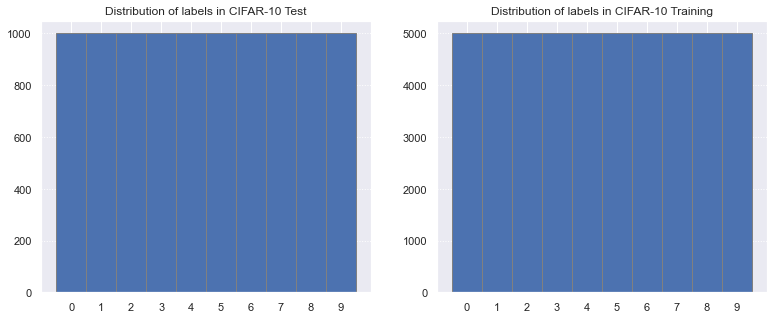

In [10]:
cifar_h_t, cifar_h_tr = plotLabelHist(y_testBatch, y_trainBatch, "CIFAR-10")

In [11]:
print("CIFAR Test -> [Min: %d, Max: %d, Mean: %d]"%
      (min(cifar_h_t[0]), max(cifar_h_t[0]), np.mean(cifar_h_t[0])))
print("CIFAR Training -> [Min: %d, Max: %d, Mean: %d]"%
      (min(cifar_h_tr[0]), max(cifar_h_tr[0]), np.mean(cifar_h_tr[0])))

CIFAR Test -> [Min: 1000, Max: 1000, Mean: 1000]
CIFAR Training -> [Min: 5000, Max: 5000, Mean: 5000]


From the above distributions, it is clearly seen that the labels are almost evenly distributed in the training set. In the test set they are equally distributed. We will have the same amount of training data for each class and thus we will train each of them equally well. Having an even distribution of test labels is also a good thing because this will lead to comparable test results among the labels.

# Validation

## Q.3. Split the training batch images into training (80%) and test datasets (20%)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_trainBatch, y_trainBatch, test_size=0.20, random_state=0)

<b>For Validation</b>,

Training sets : X_train, y_train

Test sets : X_test, y_test


<b>For Test data from CIFAR-10 dataset</b>,

Test sets : X_testBatch, y_testBatch

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 32, 32)
(40000, 1)
(10000, 32, 32)
(10000, 1)


## Q.4. Flattening of the images

In [14]:
X_train = np.array(X_train).reshape(len(X_train), 1024).astype(float)
X_train.shape

(40000, 1024)

In [15]:
y_train = y_train.reshape(len(y_train))
print(y_train.shape)
y_test = y_test.reshape(len(y_test))
print(y_test.shape)

(40000,)
(10000,)


In [16]:
X_train

array([[108., 102.,  86., ..., 238., 161., 141.],
       [141., 144., 146., ..., 111., 101.,  94.],
       [120., 131., 138., ...,  42.,  44.,  43.],
       ...,
       [202., 191., 226., ..., 156., 145., 157.],
       [255., 255., 255., ..., 255., 255., 255.],
       [199., 174., 173., ..., 221., 222., 226.]])

In [17]:
X_test = np.array(X_test).reshape(len(X_test), 1024).astype(float)
X_test.shape

(10000, 1024)

# Q.5. Naive Bayes classifier where each P(X_i|Y) is a GMM with 2 Gaussian distributions

There are 40000 samples and 1024 features in training set with total number of 10 classes.
There will be 1 Gausian Mixture Model with 2 Gaussians for each class. Hence, the mean and variance of the parameters are 3d matrices with shape (10 x 2 x 1024) which implies we have 1024 features each having 2 means and variances for 2 Gaussians.

In [18]:
class GMMNaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        n_comp = 2 #
        
        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes,n_comp, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes,n_comp, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
        
        # Dividing the feature vector X with two gaussians
        self._gmm = GaussianMixture(n_components = 2, random_state = 0)
        self._gmm.fit(X)
        
        def sigma(covar):
            var = np.zeros(1024,dtype=np.float64)
            for i in range(1024):
                for j in range(1024):
                    if i == j:
                        var[i] = covar[i][j]
            return var
                    
        # Calculation of parameters of GMM in P(X/Y) for each class 
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            
            gm = GaussianMixture(n_components=2, random_state=0)
            gm.fit(X_c)
            self._mean[idx,:,:] = gm.means_
            
            self._var[idx,0:1,:] = sigma(gm.covariances_[0])
            self._var[idx,1:2,:] = sigma(gm.covariances_[1])
            
           
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            
        
       
        
    def predict(self, X):
        i = self._gmm.predict(X)
        y_pred = []
        for k in range(X.shape[0]):
            y_pred.append(self._predict(X[k],i[k]))
        return np.array(y_pred)

    def _predict(self, x,j):
        posteriors = []
        
        
        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx,j, x)))
            posterior = prior + posterior
            posteriors.append(posterior)
        
        
        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx,j, x):
        
        mean = self._mean[class_idx][j]
        var = self._var[class_idx][j]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [19]:
# Train the model
nb = GMMNaiveBayes()
nb.fit(X_train,y_train)

In [20]:
y_pred_train = nb.predict(X_test)

## Q.6. Parameters

In [21]:
print("Mean : ",nb._mean)

Mean :  [[[196.30137798 194.99511305 195.57268397 ... 173.23387972 172.72349425
   173.44681602]
  [130.92997451 130.2341502  130.80057885 ...  97.21821697  96.88505616
    97.04582639]]

 [[204.86228814 204.56355932 206.55155367 ... 167.28601695 168.34039548
   169.40960452]
  [100.60662048 100.13510393 100.53849115 ... 107.39068514 107.98691301
   109.01963048]]

 [[170.59202149 170.52020475 171.36269102 ... 153.21604155 153.67832253
   154.42907672]
  [ 94.07563705  94.49721007  95.86893347 ...  98.18092386  97.29996132
    96.45208854]]

 ...

 [[ 89.33847842  87.8539497   88.14793994 ... 119.46274817 119.10479267
   119.92338609]
  [191.83005003 190.25000162 190.73041526 ... 133.82865356 135.10236709
   136.65739147]]

 [[194.31235057 193.70000088 194.75428684 ... 119.58100736 120.54892674
   121.55703049]
  [120.29137932 119.36596571 119.94225338 ...  92.42749623  92.88267498
    93.77232992]]

 [[136.11147068 135.15911039 136.15589832 ... 114.2941402  115.31394513
   116.1051774

In [22]:
print("Variance : ",nb._var)

Variance :  [[[1841.32596448 1803.41591915 1775.91604908 ... 2946.80189713
   2982.57247597 3006.98541269]
  [3316.88040029 3218.04838781 3212.80177101 ... 2392.53385323
   2412.78871346 2506.85987352]]

 [[3134.67242062 2916.9663002  2718.92672175 ... 4249.16748909
   4150.53949915 4208.24606695]
  [4506.67435286 4374.76581259 4353.05221458 ... 3055.73458706
   2990.5056034  2996.3402623 ]]

 [[2628.90065175 2521.53037748 2466.61759731 ... 2943.59351372
   2941.27667233 2972.47788542]
  [2632.16702008 2579.52713941 2573.38672271 ... 2386.41020089
   2396.52613427 2535.03744452]]

 ...

 [[3472.61382118 3281.42217966 3236.34243778 ... 2750.37493457
   2826.4349201  2936.19925436]
  [3123.45230475 3070.11695453 3006.18795163 ... 2894.81409441
   2930.66498146 3078.87156577]]

 [[1798.69129667 1734.23337507 1706.89268532 ... 2619.69324025
   2614.91775633 2716.4111001 ]
  [3337.15731777 3225.59644511 3203.72078169 ... 3066.34292835
   3087.26817075 3173.34011214]]

 [[4780.66675434 4569.

In [23]:
def diagSum(con):
    sum = 0
    for i in range(con.shape[0]):
        for j in range(con.shape[0]):
            if i == j:
                sum += con[i][j]
    return sum

In [24]:
train_conf_matrix = confusion_matrix(y_test,y_pred_train)
print(train_conf_matrix)

[[220  21  60  13 148  26 117  85 160 154]
 [123 173  46  60  59  42 114  65 102 202]
 [115  25 112  37 231  34 260  93  44  65]
 [ 98  54  65  86  94  96 281 125  55  76]
 [103  12  70  29 251  15 278 114  41  54]
 [ 79  44  63  44  92 137 229 186  76  66]
 [ 89  20 146  69 204  40 263  45  31  46]
 [120  57  68  38 125  61 170 209  43 108]
 [125  40  21  20 114  46  69  64 360 130]
 [164 156  28  28  40  15  86  70  98 355]]


## Q.6. Training Accuracy

In [25]:
sum = diagSum(train_conf_matrix)
print(sum)
print(f'Training Accuracy : {sum/X_test.shape[0]}')

2166
Training Accuracy : 0.2166


# Next Goal : Estimate the Test Accuracy from the test_batch of CIFAR-10 dataset

## Flattening of the test data images from test_batch

In [26]:
# Converting the test data into grayscale images is already done before.So, X_testBatch set is in grayscale format.

X_testBatch = np.array(X_testBatch).reshape(len(X_testBatch), 1024).astype(float)
X_testBatch.shape

(10000, 1024)

In [27]:
y_pred_test = nb.predict(X_testBatch)

In [28]:
y_testBatch = y_testBatch.reshape(len(y_testBatch))
print(y_testBatch.shape)

(10000,)


In [29]:
def diagSum(con):
    sum = 0
    for i in range(con.shape[0]):
        for j in range(con.shape[0]):
            if i == j:
                sum += con[i][j]
    return sum

In [30]:
test_conf_matrix = confusion_matrix(y_testBatch, y_pred_test)
print(test_conf_matrix)

[[252  22  65   9 159  24 124  82 146 117]
 [128 190  43  66  45  35 131  60 103 199]
 [124  21 108  36 189  42 260 115  46  59]
 [ 84  58  75  63 124  90 226 134  56  90]
 [ 81  12  97  41 267  20 293 100  42  47]
 [ 95  32  53  54 104 162 201 169  76  54]
 [105  23 150  71 223  51 261  45  25  46]
 [124  53  67  33 103  66 158 243  42 111]
 [100  42  16  13 117  40  67  60 406 139]
 [143 159  43  23  41  13  83  75 100 320]]


## Test Accuracy

In [31]:
sum = diagSum(test_conf_matrix)
print(sum)
print(f'Test Accuracy : {sum/X_testBatch.shape[0]}')

2272
Test Accuracy : 0.2272
